## 1. Import Libraries

In [51]:
import os
import spacy
import pandas as pd
import re
from numpy.core.defchararray import find
import random
import matplotlib.pyplot as plt

print("spaCy version: ", spacy.__version__)

import numpy
numpy.random.seed(0)

spaCy version:  3.0.6


## 2. Download and Load Spacy Language Model

In [46]:
#Download spacy small model
# !python -m spacy download en_core_web_sm
# Load SpaCy model
nlp = spacy.load("en_core_web_sm")
# nlp = spacy.blank('en')


## 3. Load processed (and cleaned) Reddit data

* Go through every sentence's all word-tag pair (except "NONE") and calculate the start and end index.
* After getting the (start, end) pair, check if this pair was already calcualted (i.e., either the start_index, OR end_index, OR both are matching with the ones in list), and if so, discard the pair and continue calculuting again, skipping over the one discarded.

In [47]:
col_names = ['text', 'entities']

data = pd.read_csv('./pf_data.csv', names=col_names)
entity_list = data.entities.to_list()

DATA = []

for index, ent in enumerate(entity_list):
  if(ent=="split_sentences"):
    continue
  
  ent = ent.split("), (")
  ent[0] = re.sub("[([]", "", ent[0])
  ent[-1] = re.sub("[)]]", "", ent[-1])

  # Initilize index list, to store pairs of (start, end) indices
  indices_list = [(-1, -1), (-1, -1)]

  annot_list = []
  start_index = 0
  end_index = 0

  # Analyze current "split_sentences"'s all word-pairs
  for index_ent, word_pair in enumerate(ent):
    # Split the word and its pair
    word_pair_list = word_pair.split("'")[1::2]
    if word_pair_list[1]!="NONE":

      # Remove any leading or beginning blank space
      word_pair_list[0] = word_pair_list[0].strip()

      start_index = find(data['text'][index].lower(), word_pair_list[0]).astype(numpy.int64)
      start_index = start_index + 0
      end_index = start_index + len(word_pair_list[0])

      # Doesn't happen, just for a check  
      if start_index == -1:
        print("-1 error for the word: ", word_pair_list[0])
        print(data['text'][index])
        break

      # Check if this start_index and/or end_index is already in the list:
      # (To prevent overlapping with already tagged words)
      while True:
        if ((start_index, end_index) in indices_list) or (end_index in [i[1] for i in indices_list]) or (start_index in [i[0] for i in indices_list]):
          start_index = find(data['text'][index].lower(), word_pair_list[0], start=end_index+1).astype(numpy.int64)
          start_index = start_index + 0
          end_index = start_index + len(word_pair_list[0])

        else:
          indices_list.append((start_index, end_index))
          break

      annot_list.append((start_index, end_index, word_pair_list[1]))

  DATA.append((data['text'][index].lower(), {"entities": annot_list}))
  # print(indices_list)



-1 error for the word:  saxophone
I see that other users have suggested bariolage As a saxophonist we typically see a small or o indicated over the notes like an accent that typically means you use an alternate or false fingering to get the different timbre as an effect I think someone familiar with reading music would know what you meant if the score had either a plus sign or a circle or some combination of the two - I think O would default to open string with the right contextual clues An example is given here
-1 error for the word:  benedettoguitars
This sounds like an archtop guitar also sometimes called a jazz box
-1 error for the word:  guitarcenter
You may be best off with a powered wedge PA type amp The JBL Eon powered wedges are pretty good See this one for example


* Randomly pull out 5 segments for test data

In [48]:
random.shuffle(DATA)

# First 5 elements form test data after shuffling
TEST_DATA = DATA[:5]

for text, annotations in TEST_DATA:
  print(text)
  print(annotations)

TRAIN_DATA = DATA[5:len(DATA)]
print("\n")

# for text, annotations in TRAIN_DATA:
#   print(text)
#   print(annotations)

print("\nLength of test data: ", len(TEST_DATA))
print("Length of train data: ", len(TRAIN_DATA))

stop suggesting plugins what is the sound of guitar
{'entities': [(45, 51, 'INSTR')]}
you did call it bass music though it s ya know bass oriented the majority of the masterpieces in production and design and the very best drops etc tend to have way more than just the bass and drums as the main instruments honestly i think you just need to broaden the range of music you re listening to hell bass music might even not be the genre that works best for you keep in mind there s a difference between what you like to listen to and what you like to produce i don t like listening to most of my own music but others do and i absolutely love the process of making my music x200b edit after reading your edit i think even with the changed perspective on what i wrote it still counts just as well majority of loud masterpieces per se in this case still have a shitton that adds to the music and in many of those the bass and drums aren t even focus points
{'entities': [(16, 20, 'EDGE'), (47, 51, 'EDGE'), 

## 4. Preparing NER pipeline

* Getting the NER from pipeline

In [5]:
ner = nlp.get_pipe("ner")

* Adding labels to the NER

In [6]:
for _, annotations in TRAIN_DATA:
  for ent in annotations.get("entities"):
    ner.add_label(ent[2])

* Add option to vary threashold for the textcat_multilabel model
*(Currently disabled)*

In [7]:
# from spacy.pipeline.textcat_multilabel import DEFAULT_MULTI_TEXTCAT_MODEL
# config = {
#    "threshold": 0.5,
#    "model": DEFAULT_MULTI_TEXTCAT_MODEL,
# }
# textcat = nlp.add_pipe("textcat_multilabel", config=config)

* Display all the components in the pipeline

In [8]:
nlp.pipe_names

['tok2vec', 'tagger', 'parser', 'ner', 'attribute_ruler', 'lemmatizer']

* Seperate enabled and disabled components of th pipeline

In [9]:
pipe_exceptions = ["ner"]
unaffected_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]

## 5. Train NER

In [33]:
# Import requirements
from spacy.util import minibatch, compounding
from spacy.training import Example
from spacy.scorer import Scorer
# from pathlib import Path

ITERATIONS = 64
DROPOUT = 0.1

scorer = Scorer()

# Store prediction and gold standard ref. for each sentence
# (to be used by Scorer)
example_list = []

# Store the PRF scores for every iteration
train_scores = []

# TRAINING THE MODEL
with nlp.select_pipes(enable=pipe_exceptions, disable=unaffected_pipes):
    # Create a list of Examples objects
    examples = []

    for text, annots in TRAIN_DATA:
        examples.append(Example.from_dict(nlp.make_doc(text), annots))

    # optimizer = nlp.create_optimizer()
    # get_examples = lambda: examples
    # optimizer = nlp.initialize(get_examples)

    for iteration in range(ITERATIONS):
        # print("Iteration: ", iteration)
        # shuffling examples  before every iteration
        random.shuffle(examples)
        losses = {}

        # optimizer = nlp.resume_training()

        # batch up the examples using spaCy's minibatch
        batches = minibatch(examples, size=compounding(4.0, 32.0, 1.001))
        for batch in batches:
            
            nlp.update(
                        batch,
                        drop = DROPOUT,  # dropout - make it harder to memorise data
                        losses=losses
                    )
            # print(batch)
            # print("Losses", losses)

        # After training every iteration, calculate scores
        for text, annot in TRAIN_DATA:
            # Create a Doc of our text
            doc_gold_text = nlp.make_doc(text)
            pred_value = nlp(text)
            reference = (Example.from_dict(doc_gold_text, annot))
            gold_standard = {"entities": annot["entities"]}
            example_list.append(Example.from_dict(pred_value, gold_standard))

        # Generate per-entity scores by comparing predicted with gold-standard values
        scores = scorer.score(examples=example_list)
        train_scores.append(scores)
        # print("All scores: ", scores)
        # print("\nents_p (aka Precision): ", scores['ents_p'])
        # print("ents_r (aka Recall): ", scores['ents_r'])
        # print("ents_f (aka fscore): ", scores['ents_f'])
        # print("\n")

c:\users\archi\pycharmprojects\tsoai\venv\lib\site-packages\spacy\training\iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "it depends on the genre depending on the genre giv..." with entities "[(68, 74, 'INSTR'), (985, 991, 'INSTR'), (1278, 12...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
c:\users\archi\pycharmprojects\tsoai\venv\lib\site-packages\spacy\training\iob_utils.py:142: UserWarning: [W030] Some entities could not be aligned in the text "this is a point i cannot stress enough move your b..." with entities "[(49, 53, 'INSTR')]". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  entities=ent_str[:50] + "..." if len(ent_str) > 50 else ent_str,
c:\users\archi

### 5.0 Plot PRF metrics

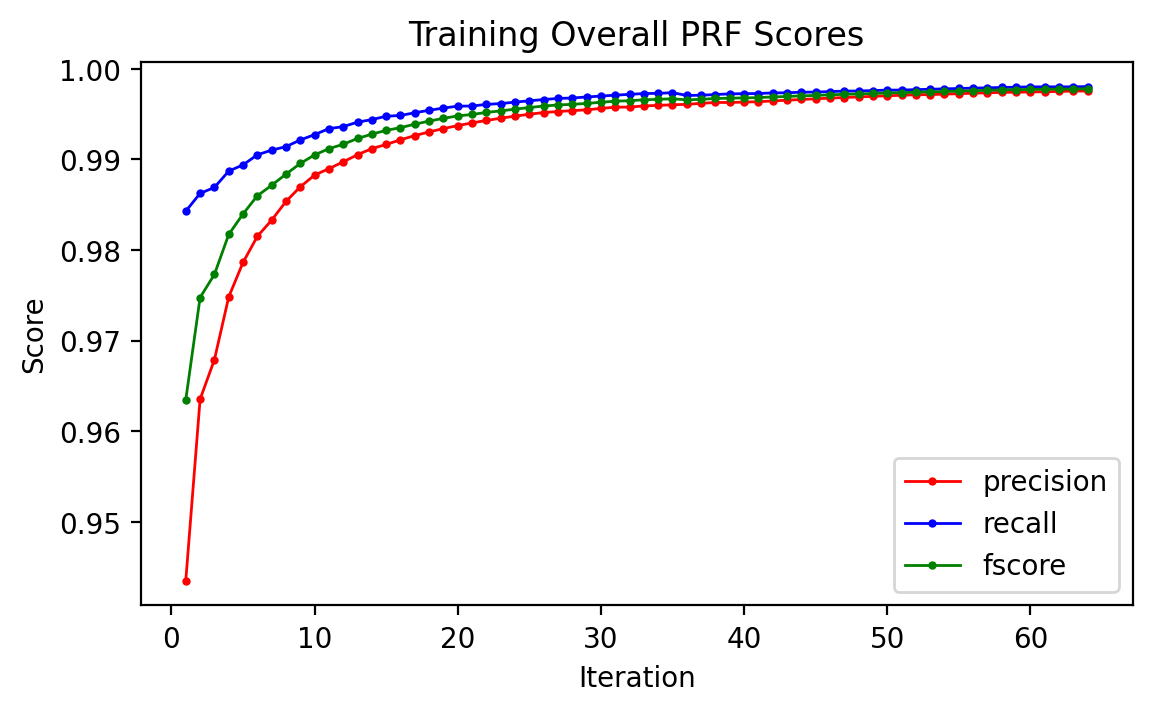

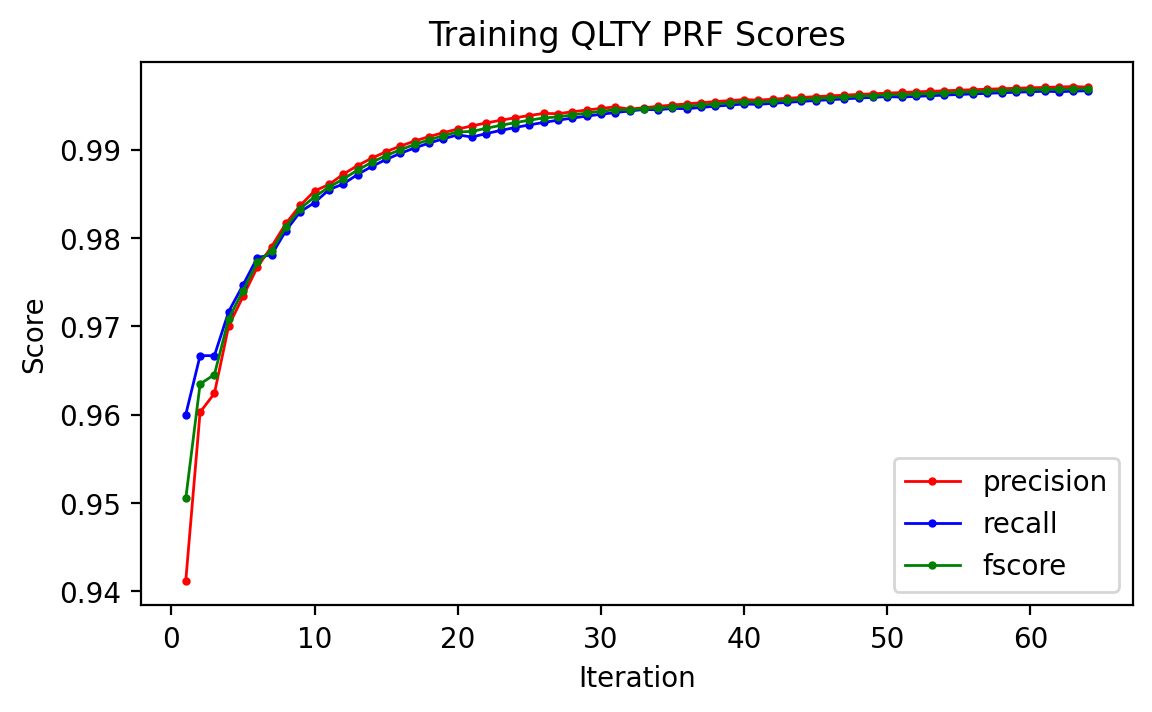

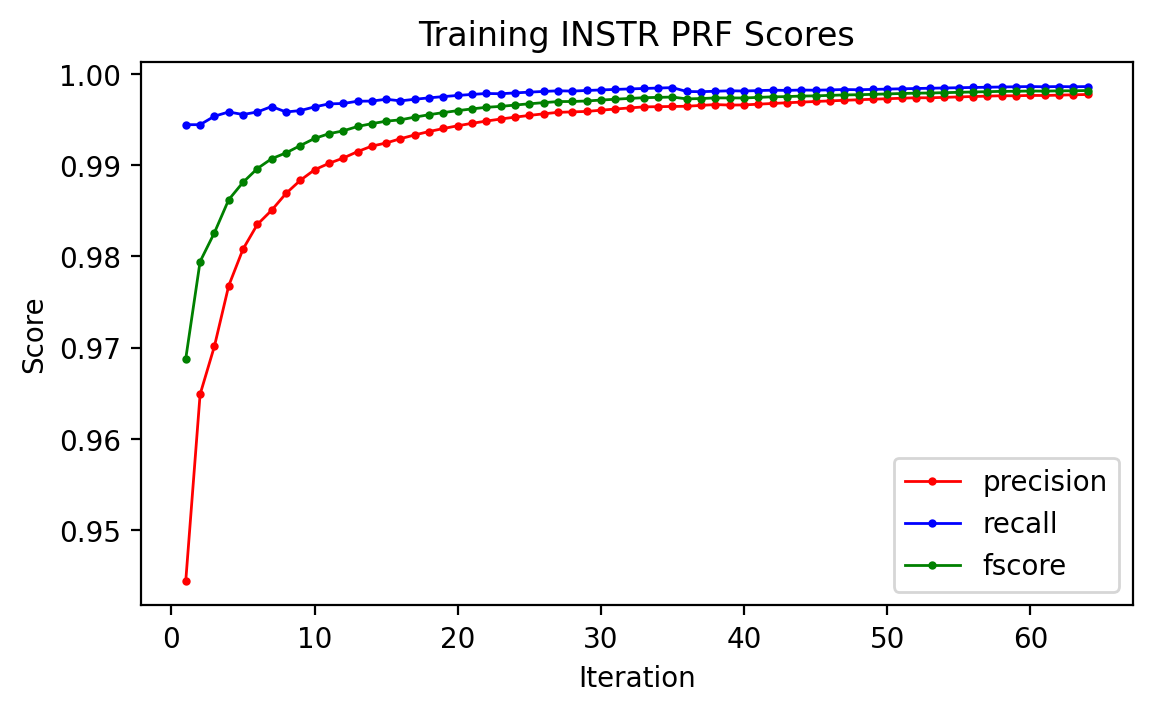

In [52]:
precision = []
recall = []
fscore = []

qlty_p = []
qlty_r = []
qlty_f = []

instr_p = []
instr_r = []
instr_f = []

# Extract P, R, F from train_score
for i, train_score in enumerate(train_scores):
    for key, cat in train_score.items():
        if key == "ents_p": precision.append(cat)
        if key == "ents_r": recall.append(cat)
        if key == "ents_f": fscore.append(cat)
        if key == "ents_per_type":
            for attribute, value in cat.items():
                if attribute == "QLTY":
                    for k, sc in value.items():
                        if k == "p": qlty_p.append(sc)
                        if k == "r": qlty_r.append(sc)
                        if k == "f": qlty_f.append(sc)
                if attribute == "INSTR":
                    for k, sc in value.items():
                        if k == "p": instr_p.append(sc)
                        if k == "r": instr_r.append(sc)
                        if k == "f": instr_f.append(sc)

def plot_graph(precision, recall, fscore, title, keyword):
    my_dpi = 200
    plt.rcParams['figure.figsize'] = 10, 5
    plt.figure(figsize=(1280 / my_dpi, 720 / my_dpi), dpi=my_dpi)
    x = list(range(1, ITERATIONS+1))
    plt.plot(x, precision, color='red', linestyle='solid', linewidth=1,
             marker='o', markerfacecolor='red', markersize=2)
    plt.plot(x, recall, color='blue', linestyle='solid', linewidth=1,
             marker='o', markerfacecolor='blue', markersize=2)
    plt.plot(x, fscore, color='green', linestyle='solid', linewidth=1,
             marker='o', markerfacecolor='green', markersize=2)
    plt.gca().legend(('precision', 'recall', 'fscore'), loc='best')
    plt.xlabel('Iteration')
    plt.ylabel('Score')
    plt.title(title)

    # If the directory does not exist, create it
    if not os.path.exists("img"):
        os.makedirs("img")

    plt.savefig("img/plot_train_prf_" + keyword + ".png", format="png", dpi=my_dpi)
    plt.show()

plot_graph(precision, recall, fscore, title="Training Overall PRF Scores", keyword="overall")
plot_graph(qlty_p, qlty_r, qlty_f, title="Training QLTY PRF Scores", keyword="qlty")
plot_graph(instr_p, instr_r, instr_f, title="Training INSTR PRF Scores", keyword="instr")

### 5.1 Test on TEST_DATA

In [40]:
for example in TEST_DATA:
  print(example[0])
  doc = nlp(example[0])
  print("Entities", [(ent.text, ent.label_) for ent in doc.ents])

i think your only other option is a pan flute talk to hohner or dannecker and see if they have any models that will give you the sound you want
Entities [('pan flute', 'INSTR')]
example i would like to find a dark sounding piano
Entities [('dark', 'QLTY'), ('piano', 'INSTR')]
example does anyone know what kind of guitar pedals i could use to generate a thin sound
Entities [('guitar', 'INSTR')]
attack timbre variation like when plucking guitar strings from different directions
Entities []
i d get a timbre wolf purely so i could mod it
Entities [('timbre wolf', 'INSTR')]


### 5.2 Print original TEST_DATA

In [41]:
for text, annotations in TEST_DATA:
  print(text)
  print(annotations)

i think your only other option is a pan flute talk to hohner or dannecker and see if they have any models that will give you the sound you want
{'entities': [(36, 45, 'INSTR')]}
example i would like to find a dark sounding piano
{'entities': [(31, 35, 'QLTY'), (45, 50, 'INSTR')]}
example does anyone know what kind of guitar pedals i could use to generate a thin sound
{'entities': [(38, 44, 'INSTR'), (78, 82, 'QLTY')]}
attack timbre variation like when plucking guitar strings from different directions
{'entities': [(43, 49, 'INSTR')]}
i d get a timbre wolf purely so i could mod it
{'entities': [(10, 21, 'INSTR')]}


### 5.3 Extracting Entities
*(Not used)*

In [ ]:
# for text, annotations in TEST_DATA:
#   print(list(annotations.values()))
#
# for ent_iterator in range(len(TEST_DATA)):
#   print(list(*TEST_DATA[ent_iterator][1].values()))
#
# TEST_DATA[0][1]

### 5.4 Evaluate scores on TEST_DATA

In [42]:
# from spacy.gold import GoldParse

scorer = Scorer()
example_list = []

for text, annot in TEST_DATA:
  # Create a Doc of our text
  doc_gold_text = nlp.make_doc(text)

  # Create gold-standard using the Doc of text
  # and original (correct) entities

  # v2.x style:
  # gold = GoldParse(doc_gold_text, entities=annot['entities'])

  # v3.x style:
  # example = Example.from_dict(doc_gold_text, {"entities": annot["entities"]})

  pred_value = nlp(text)
  reference = (Example.from_dict(doc_gold_text, annot))
  gold_standard = {"text": doc_gold_text, "entities": annot["entities"]}

  example_list.append(Example.from_dict(pred_value, gold_standard))

# Generate per-entity scores by comparing predicted with gold-standard values
scores = scorer.score(examples=example_list)

print("All scores: ", scores)

print("\nents_p (aka Precision): ", scores['ents_p'])
print("ents_r (aka Recall): ", scores['ents_r'])
print("ents_f (aka fscore): ", scores['ents_f'])

print("\nINSTR: ", scores['ents_per_type']['INSTR'])
print("QLTY: ", scores['ents_per_type']['QLTY'])

All scores:  {'token_acc': 1.0, 'token_p': 1.0, 'token_r': 1.0, 'token_f': 1.0, 'sents_p': None, 'sents_r': None, 'sents_f': None, 'tag_acc': None, 'pos_acc': None, 'morph_acc': None, 'morph_per_feat': None, 'dep_uas': None, 'dep_las': None, 'dep_las_per_type': None, 'ents_p': 1.0, 'ents_r': 0.7142857142857143, 'ents_f': 0.8333333333333333, 'ents_per_type': {'INSTR': {'p': 1.0, 'r': 0.8, 'f': 0.888888888888889}, 'QLTY': {'p': 1.0, 'r': 0.5, 'f': 0.6666666666666666}}, 'cats_score': 0.0, 'cats_score_desc': 'macro F', 'cats_micro_p': 0.0, 'cats_micro_r': 0.0, 'cats_micro_f': 0.0, 'cats_macro_p': 0.0, 'cats_macro_r': 0.0, 'cats_macro_f': 0.0, 'cats_macro_auc': 0.0, 'cats_f_per_type': {}, 'cats_auc_per_type': {}}

ents_p (aka Precision):  1.0
ents_r (aka Recall):  0.7142857142857143
ents_f (aka fscore):  0.8333333333333333

INSTR:  {'p': 1.0, 'r': 0.8, 'f': 0.888888888888889}
QLTY:  {'p': 1.0, 'r': 0.5, 'f': 0.6666666666666666}


* Old (small) dataset

| Experiment | Dropout | Iterations |   P  |   R  |   F  | QLTY<br>P | QLTY<br>R | QLTY<br>F | INSTR<br>P | INSTR<br>R | INSTR<br>F |
|:----------:|:-------:|:----------:|:----:|:----:|:----:|:---------:|:---------:|:---------:|:----------:|:----------:|:----------:|
|      1     |   0.1   |     64     |  1.0 | 0.71 | 0.83 |    1.0    |    0.5    |    0.67   |     1.0    |     0.8    |    0.89    |
|      2     |   0.1   |     64     | 0.84 | 0.42 | 0.56 |    0.5    |    0.17   |    0.25   |     1.0    |    0.67    |     0.8    |
|      3     |   0.1   |     64     | 0.67 | 0.27 | 0.38 |     0     |     0     |     0     |     1.0    |    0.45    |    0.62    |
|      4     |   0.1   |     64     | 0.59 |  0.5 | 0.54 |    1.0    |    0.6    |    0.75   |    0.37    |     0.4    |    0.38    |


* New (larger) dataset

TODO

### 5.5 Calculate ROC-AUC

* `scorer.score_cats()` requires spaCy v3 :(
* *TODO:* Fix ROC-AUC outputs
* *Update:* `Scorer.score_cats()` probably not required as `Scorer.score()` also outputs these same metrics

In [49]:
# labels = ["QLTY", "INSTR"]
#
# # for example in TEST_DATA:
# cat_scores = scorer.score_cats(example_list, attr="cats", labels=labels)
# print(cat_scores)
# for key, cat in cat_scores.items():
#     print(key)
#     if isinstance(cat, float) or isinstance(cat, str):
#         print("\t", cat)
#     else:
#         for attribute, value in cat.items():
#             print('\t{} : {}'.format(attribute, value))

## 6. Test on custom unseen data

In [44]:
doc = nlp("Play me a guitar, and it shouldn't be distorted.")
print("Entities", [(ent.text, ent.label_) for ent in doc.ents])

doc = nlp("Give me a sharp cello.")
print("Entities", [(ent.text, ent.label_) for ent in doc.ents])

doc = nlp("I used to play guitar, now I play violin and it has some kind of distortion.")
print("Entities", [(ent.text, ent.label_) for ent in doc.ents])

Entities [('guitar', 'INSTR'), ('distorted', 'QLTY')]
Entities [('sharp', 'QLTY')]
Entities [('guitar', 'INSTR'), ('violin', 'INSTR'), ('distortion', 'QLTY')]
